# Install environment

In [8]:
RANDOM_STATE = 42
COLAB = False # если на колабе то тру соответственно 

In [9]:
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    
    !pip install catboost
    !pip install sktime
    !pip install tqdm

In [10]:
import numpy as np
import pandas as pd

from collections import Counter
from tqdm import tqdm

from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score


import warnings
warnings.filterwarnings("ignore")
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

# Model code

In [11]:
import shap
import pickle
from math import cos, asin, sqrt, pi
from tracks.tracks_preprocessing import Tracks_preprocessing
from nlp.nlp_model import get_model
from sklearn.feature_selection import RFE

# formula using pythogorian theorem
# (as distances are not large, we can approximate earth rounding)
def get_distance(lat1,lon1,lat2,lon2):
    delta_lat = pow(lat2-lat1,2)
    delta_lon = pow(lon2-lon1,2)
    return np.round(sqrt(delta_lat+delta_lon)*100, 3)    

class Model:
    def __init__(self):        
        self.model = None
        self.model_tracks = None

        self.counter_words = {}
    
    def count_words(self, x):
        return len(x.split(" "))

    def check_sentence(self, sentence, words_type):
        words_count = 0
        for word in sentence.split(" "):
            word = word.lower().replace(',', '').replace('.', '')

            if (word not in list(self.counter_words.keys()) or len(self.counter_words[word]) == 2): continue

            if (words_type == self.counter_words[word][2]): 
                words_count += 1
        return words_count
        
    def NLP_features(self, X: pd.DataFrame,y:pd.DataFrame,comments: pd.DataFrame):
        self.NLP_model, result = get_model(X,y, comments)
        self.nlp_features=result
        print(f"NLP FEATURES {result}")
        return result

    def add_features(self, X):
        comment_phrases = list(X.comment.value_counts().index[: 5]) + ["---"]
        
        X["is_comment"] = (~np.isin(X.comment, comment_phrases)).astype(int)
        X['dttm'] = pd.to_datetime(X.dttm)
        X['hour'] = X.dttm.apply(lambda x: x.hour)
        X['traff_jam'] = ((X.hour > 6) & (X.hour < 10)) | ((X.hour > 17) & (X.hour < 23))
        X['traff_jam'] = X.traff_jam.astype(int)
        X['weekday'] = X.dttm.apply(lambda x: x.weekday())
        X['holiday'] = (X.weekday >= 5).astype(int)
        X["count_words"] = [-1] * X.shape[0]
        X.loc[X.is_comment == True, "count_words"] = X[X.is_comment == True].comment.apply(lambda x: self.count_words(x))
        X["speed"] = X.distance / (X.duration / 60)
        X['agg_words'] = X.comment.apply(lambda x: self.check_sentence(x, "aggressive"))
        X['normal_words'] = X.comment.apply(lambda x: self.check_sentence(x, "normal"))
        X['distance_thresh'] = ((X.distance > 5) & (X.distance < 20)).astype(int)
        
        return X
    
    def gen_speed(self, tracks):
        tracks['speed'] = np.zeros(tracks.shape[0])
        for i in tqdm(range(1, len(tracks))):
            tracks.iloc[i, tracks.columns.get_loc('speed')] = get_speed(tracks.iloc[i-1, tracks.columns.get_loc('lat_')], tracks.iloc[i-1, tracks.columns.get_loc('lon_')],
                                        tracks.iloc[i, tracks.columns.get_loc('lat_')], tracks.iloc[i, tracks.columns.get_loc('lon_')], tracks.iloc[i-1, tracks.columns.get_loc('dt')], tracks.iloc[i, tracks.columns.get_loc('dt')])
        return tracks
    
    def estimate(self, X, y):
        print('ESTIMATION')
        print(X.shape)
        print(y.shape)
        print(self.model.predict(X))
        print(roc_auc_score(y, self.model.predict(X)))
        return roc_auc_score(y, self.model.predict(X))
    
    def train_test_split_(self, X, y, test_size, X_ss=None, y_ss=None, random_state=RANDOM_STATE):
        assert X.shape[0] == y.shape[0]
        if (X_ss is not None):
            X_ss_full, y_ss_full = self.label_shuffle(X, y, X_ss, y_ss, random_state = random_state)
            
            len_train = len(X_ss_full) - round(len(X_ss_full) * test_size)
            
            x_train = X_ss_full[: len_train]
            x_train.drop('ss', axis = 1, inplace = True)
            
            x_test = X_ss_full.iloc[len_train + 1:]
            x_test = x_test[x_test.ss == 0]
            x_test.drop('ss', axis = 1, inplace = True)
            
            y_train = y_ss_full[: len_train]
            y_train.drop('ss', axis = 1, inplace = True)
            
            y_test = y_ss_full.iloc[len_train + 1:]
            y_test = y_test[y_test.ss == 0]
            y_test.drop('ss', axis = 1, inplace = True)
            
            return (x_train, x_test, y_train, y_test)
        
        len_train = len(X) - round(len(X) * test_size)
        
        X = X.sample(frac=1, random_state=random_state)
        y = y.sample(frac=1, random_state=random_state)
        
        return (X[: len_train], X[len_train :], y[: len_train], y[len_train :])
    
    def train(self, X_train, X_test, y_train, y_test, categorical_feature, random_state=RANDOM_STATE):
        print(f"Train size: {X_train.shape}")
        print(f"Test size: {X_test.shape}")
        print(f'TRAIN HEAD: \n {X_train.head()}')

        print('y_TRAIN')
        print(y_train.head())
        print('X_TRAIN')
        print(X_train.head())
        non_aggressive = len(y_train)-sum(y_train)
        aggressive = sum(y_train)
        class_weights = (1, int(non_aggressive/aggressive))

        self.model = CatBoostClassifier(iterations=1000,
                           depth=6,
                           silent=False,
                           loss_function='Logloss',
                           class_weights=class_weights,
                           random_state=random_state)

        #rfe_selector = RFE(self.model, n_features_to_select = 80, step=1)
        #rfe_selector.fit_transform(X_train, y_train)
        #text = rfe_selector.get_feature_names_out()
        #ranking = rfe_selector.ranking_
        #support = rfe_selector.support_

        #with open('log.txt', 'a') as f:
        #    f.write('FEATURES WHILE TRAINING \n' +"\n".join([''.join(x) for x in X_train.columns]))
        #    f.write('\nRFE FEATURES\n' + '\n'.join([''.join(x) for x in text]))
        #    f.write(ranking)
        #    f.write(support)

        self.model.fit(X_train, y_train, cat_features=X_train.select_dtypes(include=['category', 'object']).columns.tolist())

        shap.initjs()
        explainer = shap.TreeExplainer(self.model)
        shap_values = explainer.shap_values(X_train)

        shap.summary_plot(shap_values, X_train)

        # get every feature's importance
        vals = np.abs(shap_values).mean(0)
        feature_names = X_train.columns()
        feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
        feature_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)
        feature_importance.to_csv('./data/feature_importance.csv')
        feature_importance.head()

        
        main_model_path = './model.pkl'
        with open(main_model_path, 'wb') as f:
            pickle.dump(self.model, f)
        
        print(y_test.shape)
        return self.estimate(X_test, y_test)
    
    def label_shuffle(self, X, y, X_ss, y_ss, random_state=RANDOM_STATE):
        X_ss['ss'] = 1
        y_ss = y_ss.to_frame()
        y_ss['ss'] = 1

        X['ss'] = 0
        y['ss'] = 0

        X_ss_full = pd.concat([X, X_ss]).sample(frac=1, random_state=random_state)
        y_ss_full = pd.concat([y, y_ss]).sample(frac=1, random_state=random_state)
        
        return (X_ss_full, y_ss_full)
    
    def train_cross_validation(self, X, y, k, categorical_features, X_ss=None, y_ss=None, random_state=RANDOM_STATE):
        chunk_size = len(X) / k
        chunks_size = [(i*chunk_size, i*chunk_size + chunk_size) for i in range(k)]
        
        result_score = []
        
        print(f"Part size: {chunk_size}")
        
        if (X_ss is not None):
            X_ss_full, y_ss_full = self.label_shuffle(X, y, X_ss, y_ss, random_state = random_state)
            
            for chunkIndex in range(len(chunks_size)):
                x_test = X_ss_full[int(chunks_size[chunkIndex][0]) : int(chunks_size[chunkIndex][1])]
                y_test = y_ss_full[int(chunks_size[chunkIndex][0]) : int(chunks_size[chunkIndex][1])]
                
                x_train = X_ss_full.drop(x_test.index, axis = 0)
                y_train = y_ss_full.drop(y_test.index, axis = 0)
                
                x_test = x_test[x_test.ss == 0]
                y_test = y_test[y_test.ss == 0]
                
                x_train.drop('ss', axis = 1, inplace = True)
                y_train.drop('ss', axis = 1, inplace = True)
                x_test.drop('ss', axis = 1, inplace = True)
                y_test.drop('ss', axis = 1, inplace = True)
                
                score = self.train(x_train, x_test, y_train, y_test, categorical_features)
                
                print(f"Chunk {chunkIndex}; Score: {score}")
                
                result_score.append((chunks_size[chunkIndex], score))
        else:            
            for chunkIndex in range(len(chunks_size)):
                x_test = X[int(chunks_size[chunkIndex][0]) : int(chunks_size[chunkIndex][1])]
                y_test = y[int(chunks_size[chunkIndex][0]) : int(chunks_size[chunkIndex][1])]
                
                x_train = X.drop(x_test.index, axis = 0)
                y_train = y.drop(y_test.index, axis = 0)
                
                score = self.train(x_train, x_test, y_train, y_test, categorical_features)
                
                print(f"Chunk {chunkIndex}; Score: {score}")
                
                result_score.append((chunks_size[chunkIndex], score))
            
        print(f"Mean score: {sum(list(map(lambda x: x[1], result_score))) / k}")
        
        return result_score
    
    # fit для semi-supervised не доделано
    def fit_ss(self, X, y, numeric_features, categorial_features, X_ss, y_ss, cross_validation=False, random_state=RANDOM_STATE):
        self.counter_words = {}
        
        X_ = X
        y_ = y
        
        self.NLP_preprocess(pd.concat([X_, X_ss]), pd.concat([y_, y_ss]))
        X_ = self.add_features(X_)[numeric_features + categorical_features]
        
        X_ss = self.add_features(X_ss)
        
        if (not cross_validation):
            X_train, X_test, y_train, y_test = self.train_test_split_(X_, y_, test_size=0.2, X_ss=X_ss, y_ss=y_ss, random_state=random_state)
            return self.train(X_train, X_test, y_train, y_test, categorical_features)
        else:
            return self.train_cross_validation(X_, y_, 5, categorical_features, X_ss=X_ss, y_ss=y_ss, random_state=random_state)
        
    def transform(self, X:pd.DataFrame, tracks:pd.DataFrame, comm_dataset:pd.DataFrame, is_training = True,random_state=RANDOM_STATE):
        if tracks is not None:
            self.preprocessing = Tracks_preprocessing() 
            if is_training:
                tracks_train, tracks_y_train = self.preprocessing.preprocess(tracks)
            else:
                tracks_train = self.preprocessing.preprocess_unlabeled(tracks)
        
        self.counter_words = {}
        
        X_ = X.set_index('order_id')
        if is_training:
            X_=X_.drop('is_aggressive', axis=1)
            y_ = tracks_y_train
        else:
            y_=None
        X_ = self.add_features(X_)

        if is_training:
            features = self.NLP_features(X_, y_,comm_dataset)
        else: 
            features = self.NLP_model.features(X_, comm_dataset)
        X_ = X_.merge(features, on='order_id', how='left')
        with open('log.txt', 'a') as f:
            f.write('after NLP features \n')
            f.write(' '.join(features))
            f.write('\n'.join([''.join(x) for x in X_.columns]))

        print(f"Table data matrix shape: {X_.shape}")
        print(f"Tracks data matrix shape: {tracks_train.shape}")
        # у датасета в виде индекса ордер айди, колонки - фичи заказа
        res_matrix = tracks_train.merge(X_, right_index=True,left_index=True)
        print('RES MATRIX')
        print(res_matrix)
        res_matrix.fillna(0, inplace=True)

        print(f"Result matrix shape: {res_matrix.shape}")
        print(f"Result matrix shape: {res_matrix.shape}")
        res_matrix = res_matrix.drop(['client_id','driver_id', 'date', 'dttm', 'to_latitude', 'to_longitude', 'from_latitude', 'from_longitude'], axis=1) 
        if is_training:
            return res_matrix, y_
        return res_matrix


    def fit(self, X:pd.DataFrame, y_:pd.DataFrame, comments:pd.DataFrame, numeric_features, categorical_features, tracks:pd.DataFrame = None, cross_validation=False, random_state=RANDOM_STATE):

        res_matrix,y_ = self.transform(X, tracks,comments, random_state,True)

        if (not cross_validation):
            X_train, X_test, y_train, y_test = self.train_test_split_(res_matrix, y_, test_size=0.3, random_state=random_state)
            return self.train(X_train, X_test, y_train, y_test, categorical_features)
        else:
            return self.train_cross_validation(X_, y_, 5, categorical_features, random_state=random_state)

    def predict_proba(self, X, add_feat=True, tracks=None):
        if (add_feat): X = self.add_features(X)
        
        X = self.add_features(X)[numeric_features + categorical_features + ["order_id"]]

        res_matrix = X.merge(tracks_train, how='left', on='order_id')
        res_matrix.fillna(0, inplace=True)
        res_matrix.drop(['order_id'], axis=1, inplace=True)

        return self.model.predict_proba(res_matrix).T[1]
    
    def predict(self, X,comm_dataset, tracks=None):
        res_matrix=self.transform(X,tracks,comm_dataset,is_training=False)
        
        return res_matrix, self.model.predict(res_matrix)
    
    def predict_thresh(self, X, thresh_above, thresh_below):
        y_unlab_full = self.predict_proba(X)
        
        y_unlab = pd.Series([-1 for i in range(len(X))])
        
        print("Thresh above: {}".format(sum(y_unlab_full >= thresh_above) / len(y_unlab_full)))
        print("Thresh below: {}".format(sum(y_unlab_full <= thresh_below) / len(y_unlab_full)))
        
        y_unlab.iloc[np.where(y_unlab_full >= thresh_above)] = 1
        y_unlab.iloc[np.where(y_unlab_full <= thresh_below)] = 0
        
        return y_unlab


# Train on labled data

In [12]:
if COLAB:
    path = '/content/drive/MyDrive/aiijc_transport_simpleteam/'
else:
    path = './'

train_labled = pd.read_csv(path + 'data/base_files/labled_train_data.csv', index_col=0, sep='\t', comment='#')
tracks_labled = pd.read_csv(path+"data/labled_train_tracks_speed.csv", index_col=0, sep=',', comment='#')
tracks_unlabled = pd.read_csv(path +"data/unlabled_train_tracks_speed.csv", index_col=0, sep=',', comment='#')

test_tracks = pd.read_csv(path +"data/test_tracks_speed.csv", index_col=0, sep=',', comment='#')
test_data = pd.read_csv(path +"data/base_files/labled_test_data.csv", index_col=0, sep='\t', comment='#')
print(test_data.columns)
test_comments = test_data[['driver_id','comment']]

labled_train_comments = pd.read_csv('data/base_files/labled_train_comments.csv', comment='#', sep='\t').drop('Unnamed: 0', axis=1)


X_ = train_labled
y_ = train_labled.iloc[:, -1:]
X_['client_rate_ride'] = X_['client_rate_ride'].fillna(X_['client_rate_ride'].mean())
X_['client_rides_cnt'] = X_['client_rides_cnt'].fillna(X_['client_rides_cnt'].mean())
X_['driver_rides_cnt'] = X_['driver_rides_cnt'].fillna(X_['driver_rides_cnt'].mean())

Index(['order_id', 'driver_id', 'client_id', 'dttm', 'date',
       'arrived_distance', 'arrived_duration', 'distance', 'duration',
       'from_latitude', 'from_longitude', 'to_latitude', 'to_longitude',
       'mark', 'client_rate_ride', 'client_rides_cnt', 'driver_rides_cnt',
       'comment'],
      dtype='object')


In [13]:
labled_train_comments = labled_train_comments.fillna('Больше нечего сказать'.lower())
test_comments = test_comments.fillna('Больше нечего сказать'.lower())

training vectorizer model...
TEXT WECTORIZER TRAINED
training vectorizer model...
CARS WECTORIZER TRAINED
training cars clustering model...
CARS CLUSTERING COMPLETED
COMM MODEL TRAINED
NLP FEATURES                                   agg_verbs_rate  agg_adjs_rate  \
order_id                                                          
6a0f322ade1a05e5c4cec4344efbce8b             0.0            0.0   
934ecbe5845426fd3f8ef7938cce2a11             0.0            0.0   
5348cb339b63eaea3b2cb57a064ce550             0.0            0.0   
309ef91c3b51e27d097642169576f67b             0.0            0.0   
3506e04e45d39c6e3033637389da1041             0.0            0.0   
...                                          ...            ...   
bd1c7382bcfa4f5981a8b98d50cdbf37             0.0            0.0   
37a2c7ddf4e0e911d1f5b827a22424c6             0.5            1.0   
675f5308235dfb532bc12c628568a431             0.0            0.0   
209184a3e7d4cff49703e03ea9329ce7             0.0            0.0  

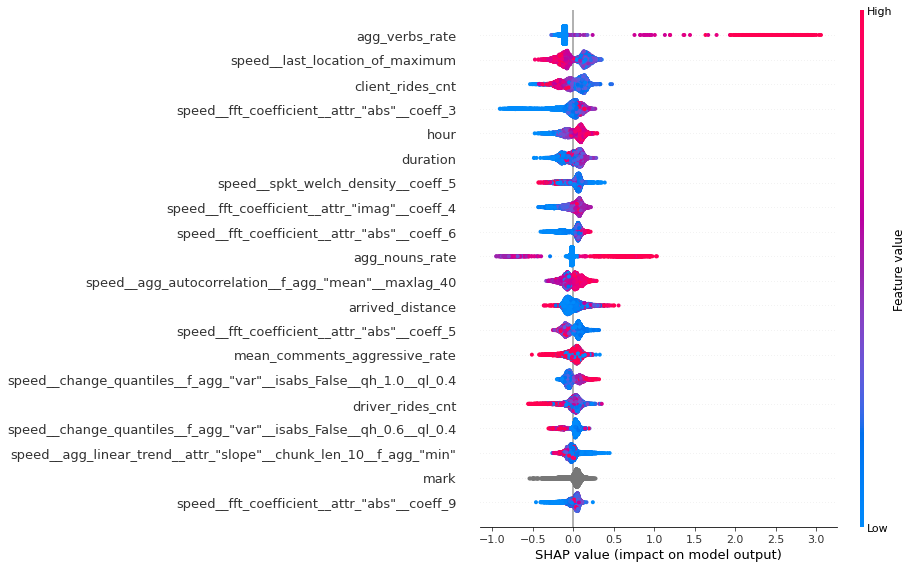

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [14]:
numeric_features = ['distance', 'arrived_distance', 'arrived_duration', 'duration', 'driver_rides_cnt', 'client_rides_cnt', 'client_rate_ride', 'count_words']

categorical_features = ['mark', 'is_comment', 'hour', 'weekday', 'agg_words', 'normal_words']
model_supervised = Model()

# код, чтобы загруизть закэшированую модель
#with open('model.pkl','rb') as f:
#    model_supervised = pickle.load(f)
model_supervised.fit(X_,y_, labled_train_comments, numeric_features, categorical_features, tracks=tracks_labled)

with open('model.pkl','wb') as f:
    pickle.dump(model_supervised, f)

In [ ]:
result = model_supervised.predict(test_data,test_comments,test_tracks) 


Feature Extraction: 100%|██████████| 40/40 [00:09<00:00,  4.05it/s]


Table data matrix shape: (1272, 33)
Tracks data matrix shape: (1272, 124)
RES MATRIX
                                  speed__fft_coefficient__attr_"abs"__coeff_3  \
000d9cf4365ad8be9b559951d0d945c7                                    25.509130   
00287e34dd884a2a69c80346541d2aef                                   220.302145   
00307c7812842b1159781c2c6375944a                                    78.431549   
0061e7abbe5544c40781ba2816b3e026                                    50.780780   
0074b0c828084e05c28035487ad2a130                                   117.050115   
...                                                                       ...   
ff209045501b1f25e8729a96a215a3d2                                   302.766730   
ff4c5997ed87ff37a3c215bab2c0916e                                   171.895503   
ff6873cfaccafec937bbed29e317d3e2                                    71.112287   
ff9745e14cda84a4550b528a8d9aa4de                                   737.061231   
ffd2c55165c42430793423c9

CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=130]="Toyota Camry": Cannot convert 'b'Toyota Camry'' to float

In [ ]:
with open('model.pkl','rb') as f:
    model_supervised = pickle.load(f)


data = model_supervised.transform(test_data, test_tracks,test_comments, is_training=False)
with open('features.txt', 'w') as f:
    f.write(' \n'.join([''.join(x) for x in data.columns]))
#print(data.iloc[0])
#data = data.drop(['dttm', 'date'], axis=1)
#shap.initjs()
#explainer = shap.TreeExplainer(model_supervised.model)
#shap_values = explainer.shap_values(data)
#shap.force_plot(explainer.expected_value, shap_values, data)


Feature Extraction: 100%|██████████| 40/40 [00:10<00:00,  3.86it/s]


                                                         driver_id  \
order_id                                                             
49430c6531d098d3b288d95d7d1e7f4f  21348747875e0b01bc492d32b49c638d   
d3fff1a829a5b5ccbccd40c9895ff4b0  398fe459519b5facba93168b71df0625   
f73533b8aab3b1d7b52488d954a46fa0  951410ef679f167e6515ea5e4d5fb92d   
43c6c249e4751b9ba0cf68de3e40a053  311ac9352166fb9b2f9153581b03ab5b   
b88dccdeaa7c5c1478915d7532082cda  cccd0c6d3ce5a7c553a1f28086beef5a   

                                                         client_id  \
order_id                                                             
49430c6531d098d3b288d95d7d1e7f4f  4d4d06feddc5669339b1cd9d7941a116   
d3fff1a829a5b5ccbccd40c9895ff4b0  2a41e0a45a19a892e960d6c4bef5c27b   
f73533b8aab3b1d7b52488d954a46fa0  9a8017ac4e8b0ce55b0dbd75c2f25445   
43c6c249e4751b9ba0cf68de3e40a053  2f9a136bb3baa4912748a981033fd272   
b88dccdeaa7c5c1478915d7532082cda  121a25147dafdb4565cf4eb6db7302f6   

                  

In [ ]:
#data, predicitons =predictions
data, predictions = result
data['is_aggressive']=predictions

In [ ]:
#test_data['submit'] = test_data.index
#test_data = test_data.set_index('order_id')
data= data.reindex(index=test_data['order_id'])
data= data.reset_index()

In [ ]:
pd.DataFrame(data.is_aggressive).to_csv('./result.csv')

In [ ]:
employees = [('Stuti', 28, 'Varanasi', 20000),
            ('Saumya', 32, 'Delhi', 25000),
            ('Aaditya', 25, 'Mumbai', 40000),
            ('Saumya', 32, 'Delhi', 35000),
            ('Saumya', 32, 'Delhi', 30000),
            ('Saumya', 32, 'Mumbai', 20000),
            ('Aaditya', 40, 'Dehradun', 24000),
            ('Seema', 32, 'Delhi', 70000)
            ]
  
# Create a DataFrame object from list 
df = pd.DataFrame(employees, 
                columns =['Name', 'Age', 
                         'City', 'Salary'])
# Show the dataframe
df

,Name,Age,City,Salary
0,Stuti,28,Varanasi,20000
1,Saumya,32,Delhi,25000
2,Aaditya,25,Mumbai,40000
3,Saumya,32,Delhi,35000
4,Saumya,32,Delhi,30000
5,Saumya,32,Mumbai,20000
6,Aaditya,40,Dehradun,24000
7,Seema,32,Delhi,70000


In [ ]:
df[['Name', 'Age', 'City']]

,Name,Age,City
0,Stuti,28,Varanasi
1,Saumya,32,Delhi
2,Aaditya,25,Mumbai
3,Saumya,32,Delhi
4,Saumya,32,Delhi
5,Saumya,32,Mumbai
6,Aaditya,40,Dehradun
7,Seema,32,Delhi
